In [92]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [93]:
orders_url = "https://drive.google.com/file/d/143CzG5DriVSPMkaL1UP4k3Y80oS8fgbV/view?usp=sharing"
orderlines_url = "https://drive.google.com/file/d/1yWO-mQfxQtnSZdCgdNlIEUrZSCW1HN5O/view?usp=sharing"
products_url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
brands_url = "https://drive.google.com/file/d/1XGyabaa4mAkjixMk3XPgx_14OoSse3rs/view?usp=sharing"

def import_csv(url):
  path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
  return pd.read_csv(path)

# Importing csvs and correcting data types
orderlines_qu = import_csv(orderlines_url)
orderlines_qu['date'] = pd.to_datetime(orderlines_qu['date'])
orders_qu = import_csv(orders_url)
orders_qu['created_date'] = pd.to_datetime(orders_qu['created_date'])
products_cl = import_csv(products_url)
brands_df = import_csv(brands_url)

# Incorporating additional information into orderlines data frame
orderlines_qu['short'] = orderlines_qu['sku'].str[:3]
orderlines_expanded = (
    orderlines_qu
    .merge(products_cl,
           on='sku')
    .merge(brands_df,
           on='short')
    .rename(columns={'long':'brand'})
    .drop(columns='short')
)
# Creating composite columns
orderlines_expanded['revenue'] = (
    orderlines_expanded['unit_price'] * orderlines_expanded['product_quantity']
)
orderlines_expanded['discount'] = (
    orderlines_expanded['price'] - orderlines_expanded['unit_price']
)
orderlines_expanded['total_discount'] = (
    orderlines_expanded['discount'] * orderlines_expanded['product_quantity']
)
orderlines_expanded['percentage_discount'] = (
    100 * orderlines_expanded['discount'] / orderlines_expanded['price']
)

## Data visualisation

##### 1. Monthly revenue before and after discounts

Text(0, 0.5, 'Revenue')

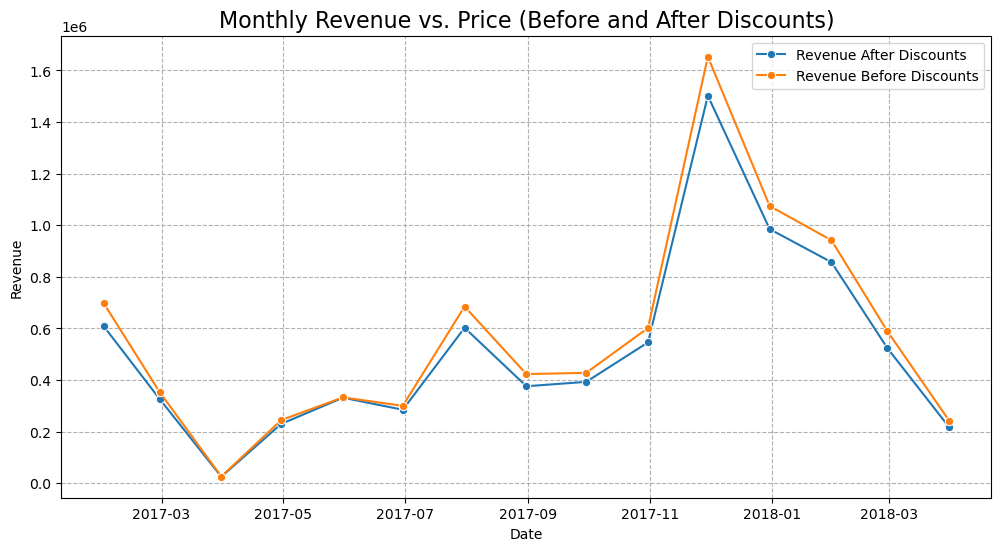

In [120]:
agg_rev_disc = orderlines_expanded.resample(
    'M', on='date'
).agg({'price': 'sum',
       'revenue': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))

sns.lineplot(data=agg_rev_disc, 
             x='date', 
             y='revenue', 
             label='Revenue After Discounts', 
             marker='o')

sns.lineplot(data=agg_rev_disc, 
             x='date', 
             y='price', 
             label='Revenue Before Discounts', 
             marker='o')

plt.title('Monthly Revenue vs. Price (Before and After Discounts)', fontsize=16)
plt.grid(True, linestyle='--')
plt.xlabel("Date")
plt.ylabel("Revenue")

##### 2. Top 10 products sold

Text(-461.2645061728395, 0.5, 'Product')

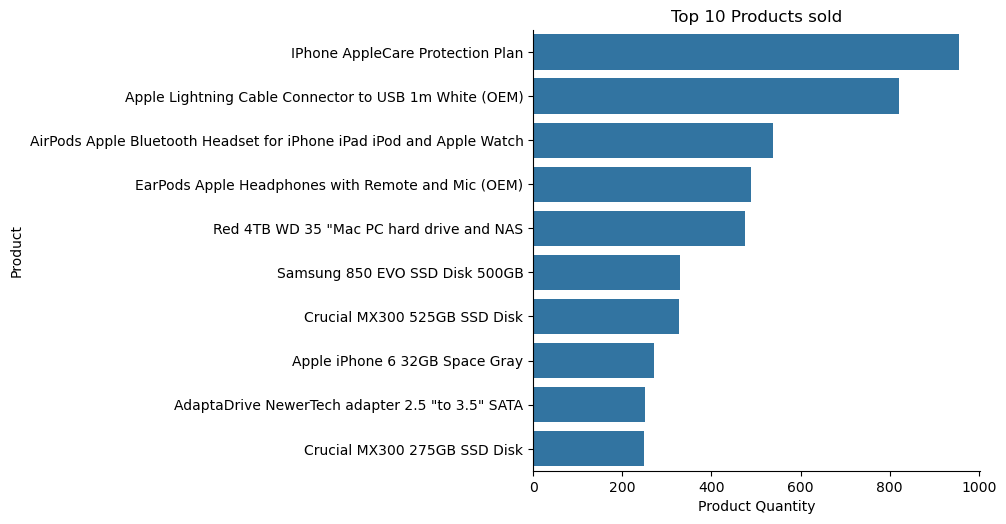

In [119]:
top_10_peoducts = orderlines_expanded.groupby('name')['product_quantity'].sum().nlargest(10).reset_index()

sns.catplot(data=top_10_peoducts, 
            kind='bar',
            y='name', 
            x='product_quantity',
            orient='h')

plt.title("Top 10 Products sold")
plt.xlabel("Product Quantity")
plt.ylabel("Product")


##### 3. Top 10 brands selling

Text(30.67530864197532, 0.5, 'Brand')

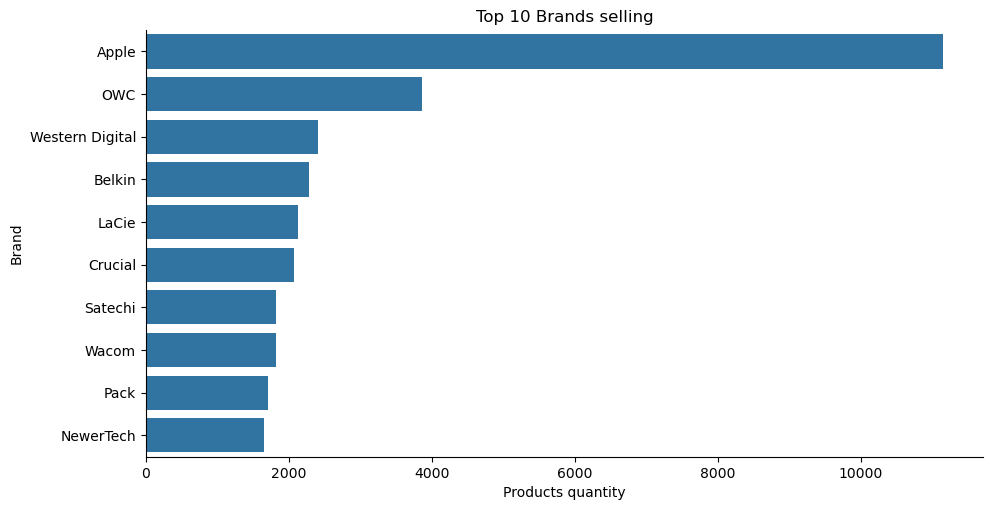

In [118]:
top_10_brands = orderlines_expanded.groupby('brand')['product_quantity'].sum().nlargest(10).reset_index()

sns.catplot(data=top_10_brands, 
            kind='bar',
            y='brand', 
            x='product_quantity',
            orient='h',
            aspect=2)
plt.title("Top 10 Brands selling")
plt.xlabel("Products quantity")
plt.ylabel("Brand")

In [97]:
orderlines_expanded.head(2)

,id,id_order,product_id,product_quantity,sku,unit_price,date,name,desc,price,in_stock,type,brand,revenue,discount,total_discount,percentage_discount
0,1119116,299545,0,1,OWC0100,47.49,2017-01-01 01:46:16,OWC In-line Digital Temperature Sensor Kit HDD...,Kit temperature sensor for HDD iMac 21 inch an...,60.99,1,12755395,OWC,47.49,13.50,13.50,22.134776
1,1119119,299546,0,1,IOT0014,18.99,2017-01-01 01:50:34,iOttie Easy View 2 Car Black Support,IPhone car holder 7 plus / 7/6 Plus / 6 / 5s /...,22.95,0,5720,iOttie,18.99,3.96,3.96,17.254902


##### 4. Top 10 brands revenue

Text(30.67530864197532, 0.5, 'Brand')

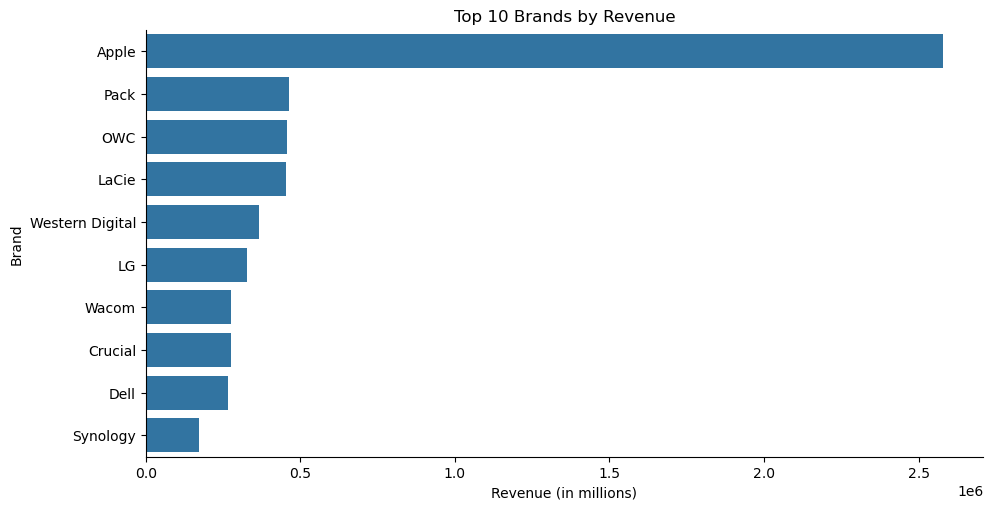

In [117]:
top_10_brands = orderlines_expanded.groupby('brand')['revenue'].sum().nlargest(10).reset_index()

sns.catplot(data=top_10_brands, 
            kind='bar',
            y='brand', 
            x='revenue',
            orient='h',
            aspect=2)

plt.title("Top 10 Brands by Revenue")
plt.xlabel("Revenue (in millions)")
plt.ylabel("Brand")

##### 5. Average discount by top 10 brands

Text(30.67530864197532, 0.5, 'Brand')

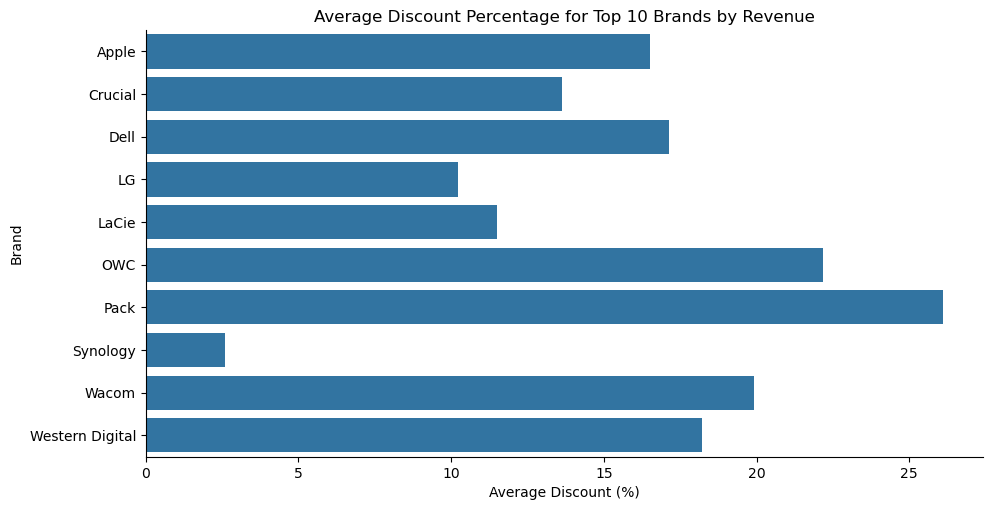

In [123]:
top_10_revenue = orderlines_expanded.groupby('brand')['revenue'].sum().nlargest(10).reset_index()

top_10_data = orderlines_expanded[orderlines_expanded['brand'].isin(top_10_revenue['brand'])]

avg_discount_top_brands = top_10_data.groupby('brand')['percentage_discount'].mean()
sns.catplot(
    data=avg_discount_top_brands.reset_index(),
    kind='bar',
    x='percentage_discount',
    y='brand',
    orient='h',
    aspect=2
)
plt.title("Average Discount Percentage for Top 10 Brands by Revenue")
plt.xlabel("Average Discount (%)")
plt.ylabel("Brand")